In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' #Kernal would repeatedly die when using matplotlib unless this line was used

%matplotlib inline 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

from datetime import datetime
import time

## Check whether to use GPU or CPU

In [2]:
if torch.cuda.is_available():
    
    device = torch.device("cuda")
    
else:
    
    device = torch.device("cpu")
    
print("Device:",device)

Device: cuda


## Loading train and test data

In [3]:
train_path = "archive\images_E_S_SB_69x69_a_03\images_E_S_SB_69x69_a_03_train"
test_path = "archive\images_E_S_SB_69x69_a_03\images_E_S_SB_69x69_a_03_test"

dataset = ImageFolder(train_path, transform = transforms.Compose([transforms.Resize((69,69)),transforms.ToTensor()]))

test_dataset = ImageFolder(test_path, transforms.Compose([transforms.Resize((69,69)),transforms.ToTensor()]))

img, label = dataset[0]

print(img.shape,label)
print("Classes: \n",dataset.classes)

torch.Size([3, 69, 69]) 0
Classes: 
 ['E', 'S', 'SB']


## Display sample image to confirm data was loaded correctly

Label : S


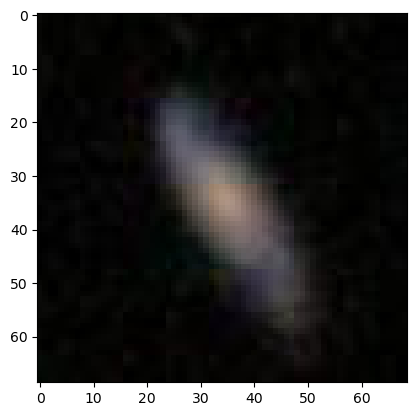

In [4]:
def display_image(img, label):
    
    print(f"Label : {dataset.classes[label]}")
    
    plt.imshow(img.permute(1,2,0))

display_image(*dataset[86670])

## Split train data into training and validation sets

In [5]:
valid_size = int(len(dataset) * 0.1)
train_size = len(dataset) - valid_size 

train_data, valid_data = random_split(dataset, [train_size, valid_size])

print("Train Data:", len(train_data))
print("Validation Data:",  len(valid_data))

Train Data: 108389
Validation Data: 12043


## Generate batches for training, validation and test sets

In [6]:
batch_size = 32

train_batches = DataLoader(train_data, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
valid_batches = DataLoader(valid_data, batch_size * 2, num_workers = 2, pin_memory = True)
test_batches = DataLoader(test_dataset, batch_size, shuffle = True, num_workers = 2, pin_memory = True)

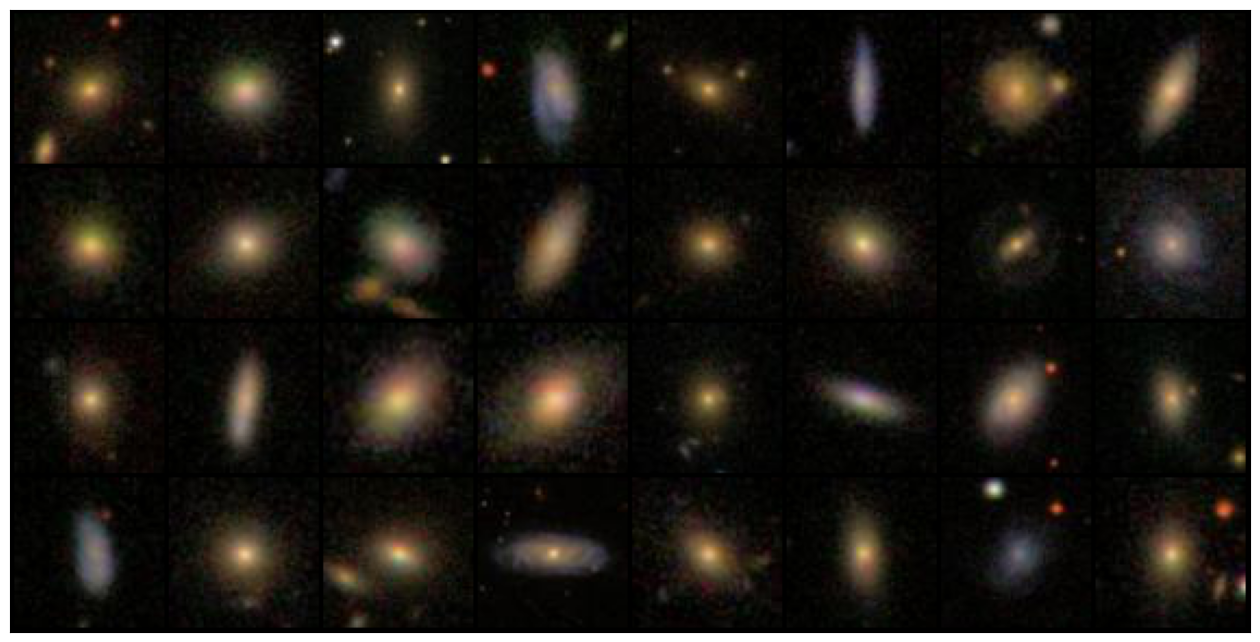

In [7]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 8).permute(1,2,0))
        break
        
show_batch(train_batches)

## Neural Network Class

In [8]:
class ImageNeuralNetwork(nn.Module):
    
    def __init__(self, learning_rate = 0.1, epochs = 5, optimiser = torch.optim.SGD):
        
        super().__init__()
        
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.optimiser = optimiser
        
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            
            nn.Linear(16384, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 12)
        )

    def forward(self, x):
        
        return self.network(x)
    
    def accuracy(self, outputs, labels):
        
        _, predictions = torch.max(outputs, dim = 1)
        
        return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

    @torch.no_grad() #Updates weights without calculating gradients
    def evaluate(self, model, valid_batches):
        
        model.eval()
        outputs = []
        
        for batch in valid_batches:
            
            images, labels = batch 
            images, labels = images.to(device), labels.to(device)
            
            predictions = model(images)
            loss = F.cross_entropy(predictions, labels)
            accuracy = self.accuracy(predictions, labels)
            
            outputs.append({"valid_loss": loss.detach(), "valid_accuracy": accuracy})
    
        #Combine losses and accuracies
        batch_loss = [x["valid_loss"] for x in outputs]
        batch_accuracy = [x["valid_accuracy"] for x in outputs]
        
        epoch_loss = torch.stack(batch_loss).mean()
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        
        return {"valid_loss": epoch_loss.item(), "valid_accuracy": epoch_accuracy.item()}
    
    def fit(self, model, train_batches, valid_batches):
    
        history = []
        optimizer = self.optimiser(model.parameters(), self.learning_rate)

        for epoch in range(self.epochs):
            
            start = datetime.now()
            model.train()
            train_losses = []

            for batch in train_batches:

                images, labels = batch 
                images, labels = images.to(device), labels.to(device)
                
                predictions = model(images)
                loss = F.cross_entropy(predictions, labels)
                
                train_losses.append(loss)
                
                loss.backward()
                
                optimizer.step()
                optimizer.zero_grad()

            result = self.evaluate(model, valid_batches)
            result["train_loss"] = torch.stack(train_losses).mean().item()
            
            print("Epoch [{}], train_loss: {:.4f}, valid_loss: {:.4f}, valid_accuracy: {:.4f}".format(
                epoch, result["train_loss"], result["valid_loss"], result["valid_accuracy"]))
            print(f"Time taken for epoch {epoch}: {datetime.now()-start}")
            
            history.append(result)

        return history

## Initialise model and set hyperparameters

In [9]:
learning_rate = 0.001
epochs = 5
optimiser = torch.optim.Adam

model = ImageNeuralNetwork(learning_rate, epochs, optimiser)
print(model)

ImageNeuralNetwork(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=16384, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_

## Fit model and get recorded loss values of each epoch

In [10]:
model.to(device)

history = model.fit(model, train_batches, valid_batches)

Epoch [0], train_loss: 0.6667, valid_loss: 0.6231, valid_accuracy: 0.7643
Time taken for epoch 0: 0:02:25.234110
Epoch [1], train_loss: 0.5305, valid_loss: 0.4772, valid_accuracy: 0.8253
Time taken for epoch 1: 0:02:20.996494
Epoch [2], train_loss: 0.4663, valid_loss: 0.4577, valid_accuracy: 0.8341
Time taken for epoch 2: 0:02:20.933783
Epoch [3], train_loss: 0.4353, valid_loss: 0.4440, valid_accuracy: 0.8404
Time taken for epoch 3: 0:02:20.982712
Epoch [4], train_loss: 0.4132, valid_loss: 0.4310, valid_accuracy: 0.8447
Time taken for epoch 4: 0:02:20.945797


## Test model with test set

In [11]:
prediction = model.evaluate(model, test_batches)

In [12]:
print("valid_loss: {:.4f}, valid_accuracy: {:.4f}".format(prediction["valid_loss"], prediction["valid_accuracy"]))

valid_loss: 0.4343, valid_accuracy: 0.8406


## Plot train and validation loss and accuracy

In [13]:
train_losses = []
valid_losses = []
valid_accuracies = []


for idx in range(len(history)):
    
    train_losses.append(history[idx]["train_loss"])
    valid_losses.append(history[idx]["valid_loss"])
    valid_accuracies.append(history[idx]["valid_accuracy"])

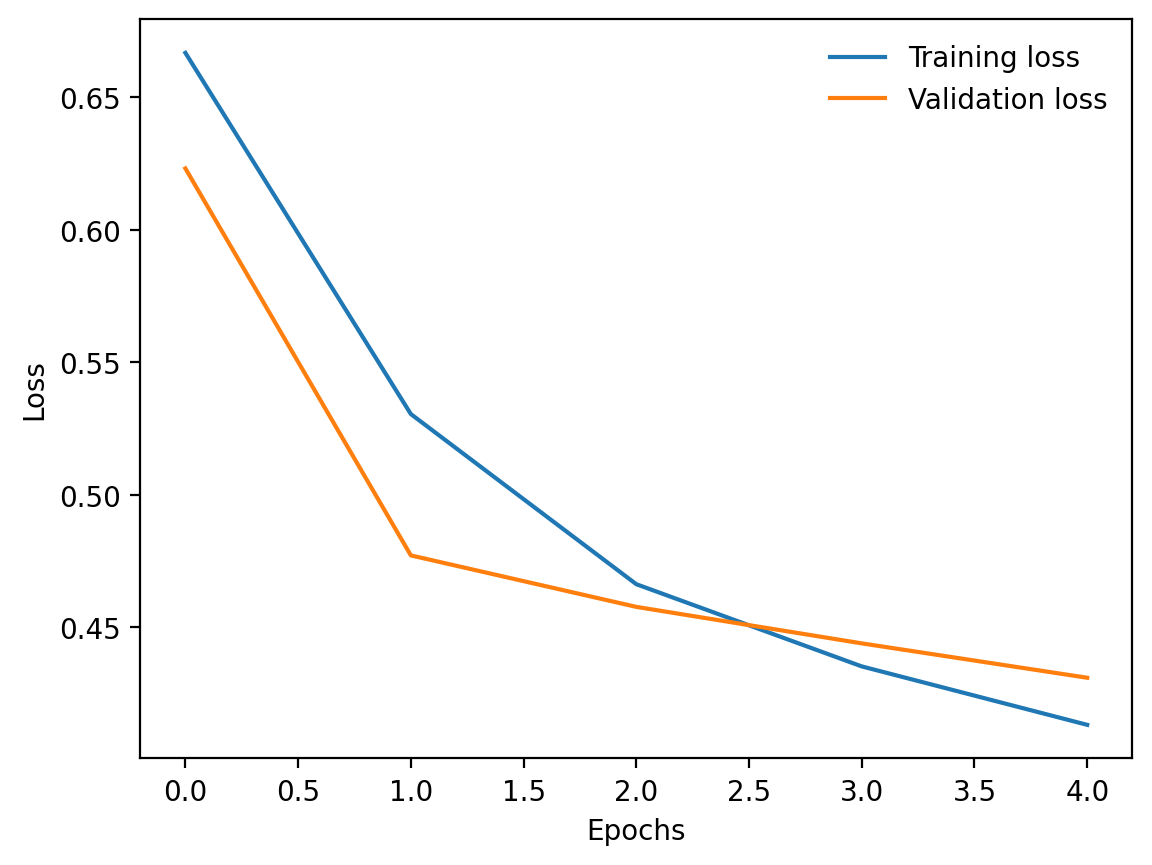

In [14]:
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

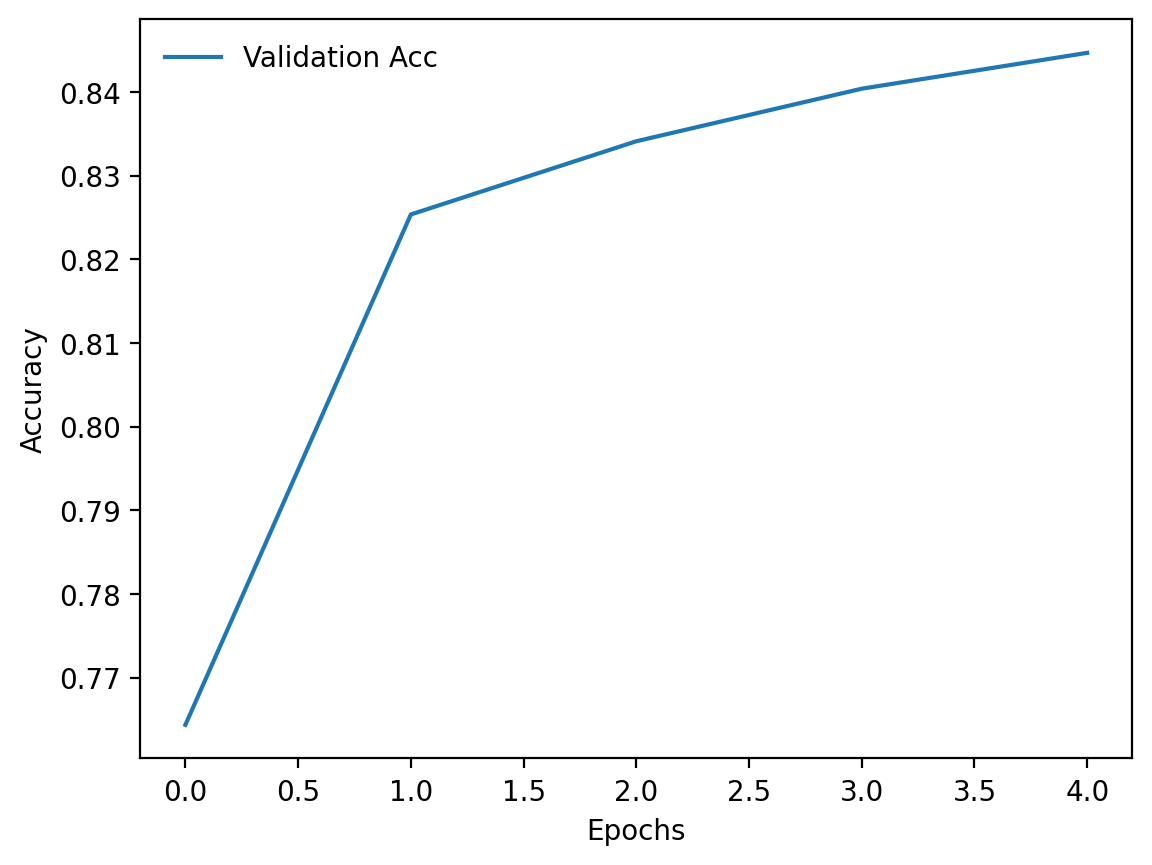

In [15]:
%config InlineBackend.figure_format = 'retina'

plt.plot(valid_accuracies, label='Validation Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon=False)